In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49,0.48,0.45), (0.25,0.24,0.26)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49,0.48,0.45), (0.25,0.24,0.26))
                                       ])

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:10<00:00, 15875701.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(




>Let us show some of the training images.


 ship  bird   cat   dog


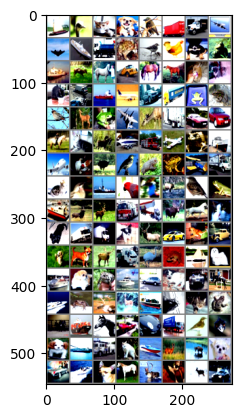

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Model

In [13]:
dropout_value = 0.1

num_groups = 4

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block - CONVOLUTION BLOCK 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 30

        # CONVOLUTION BLOCK 2
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # TRANSITION BLOCK 1 - CONVOLUTION BLOCK 3
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 28
        self.P1 = nn.MaxPool2d(2, 2) # output_size = 14

        # CONVOLUTION BLOCK 4
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 12

        # CONVOLUTION BLOCK 5
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # TRANSITION BLOCK 2 - CONVOLUTION BLOCK 6
        self.c6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 10
        self.P2 = nn.MaxPool2d(2, 2) # output_size = 5

        # CONVOLUTION BLOCK 7
        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 3

        # CONVOLUTION BLOCK 8
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        # CONVOLUTION BLOCK 9
        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) # output_size = 1

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        x = self.c3(x)
        x = self.P1(x)
        x = self.C4(x)
        x = self.C5(x)
        x = self.c6(x)
        x = self.P2(x)
        x = self.C7(x)
        x = self.C8(x)
        x = self.C9(x)
        x = self.GAP(x)
        x = self.C10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
         GroupNorm-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           9,216
              ReLU-6           [-1, 32, 28, 28]               0
         GroupNorm-7           [-1, 32, 28, 28]              64
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]           2,048
        MaxPool2d-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]          18,432
             ReLU-12           [-1, 32, 12, 12]               0

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.630833625793457 Batch_id=390 Accuracy=31.69: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]



Test set: Average loss: 1.5422, Accuracy: 4305/10000 (43.05%)

EPOCH: 1


Loss=1.4807684421539307 Batch_id=390 Accuracy=44.66: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 1.4062, Accuracy: 4873/10000 (48.73%)

EPOCH: 2


Loss=1.269742488861084 Batch_id=390 Accuracy=50.72: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]



Test set: Average loss: 1.3233, Accuracy: 5173/10000 (51.73%)

EPOCH: 3


Loss=1.2856082916259766 Batch_id=108 Accuracy=55.13:  28%|██▊       | 108/391 [00:05<00:16, 16.77it/s]

In [ ]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")